In [3]:
pip install tldextract

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
for dirname, _, filenames in os.walk(r'C:\Users\Dell\OneDrive\Desktop\PhishShield\dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Dell\OneDrive\Desktop\PhishShield\dataset\malicious_phish.csv


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tldextract
from urllib.parse import urlparse
import re 
import joblib
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from urllib.parse import urlparse, unquote
from sklearn.preprocessing import label_binarize


In [6]:
# Define the file path
file_path = r'C:\Users\Somashekar\OneDrive\Desktop\PhisShield\malicious_phish.csv'

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(file_path)

In [7]:
data.head() # Display the first few rows of the DataFrame

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [8]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [8]:
data.shape

(651191, 2)

In [9]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [10]:
# Count the number of values for each 'type'
type_counts = data['type'].value_counts()
type_counts

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

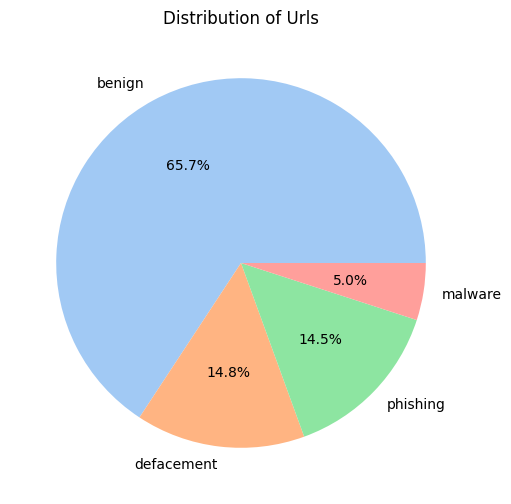

In [11]:
# Assuming you have type_counts as a pandas Series containing the count of each type
plt.figure(figsize=(6, 6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of Urls')
plt.show()

In [12]:
# Remove "www." from URLs and update the 'url' column
data['url'] = data['url'].str.replace('www.', '')

In [13]:
# Print the first few rows of the updated DataFrame
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [14]:
# Create a dictionary to map types to categories
type_to_category = {
    "benign": 0,
    "defacement": 1,
    "phishing": 2,
    "malware": 3
}

# Add a new 'Category' column based on the 'type' column
data['Category'] = data['type'].map(type_to_category)

In [15]:
data.head()

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [16]:
# Add a new 'URL_Length' column with the length of each URL
data['URL_Length'] = data['url'].apply(len)

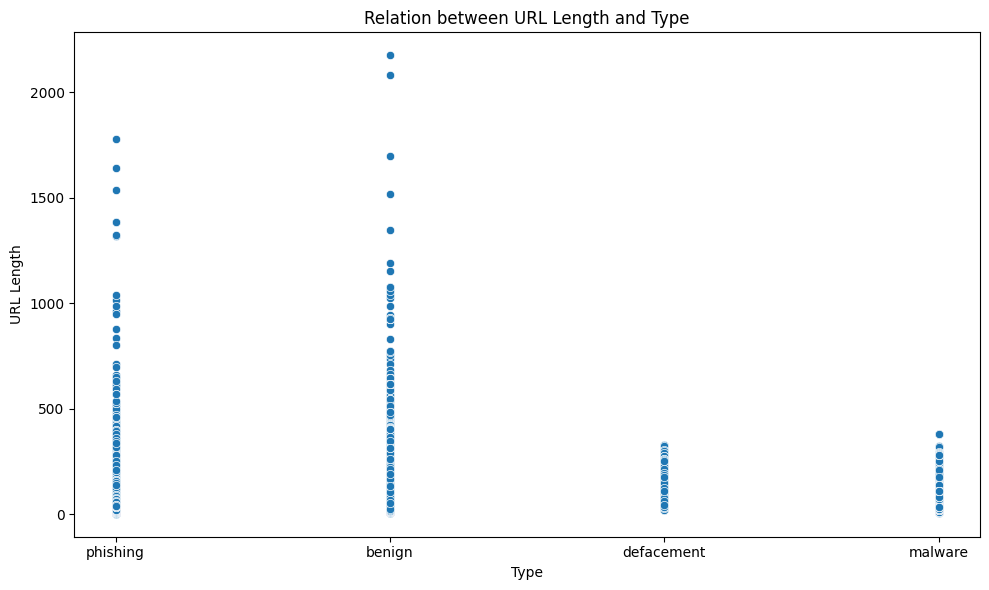

In [17]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='URL_Length')
plt.title("Relation between URL Length and Type")
plt.xlabel("Type")
plt.ylabel("URL Length")
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16736\2130253848.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='type', y='URL_Length',palette="bright", ci=None)
C:\Users\Dell\AppData\Local\Temp\ipykernel_16736\2130253848.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='type', y='URL_Length',palette="bright", ci=None)


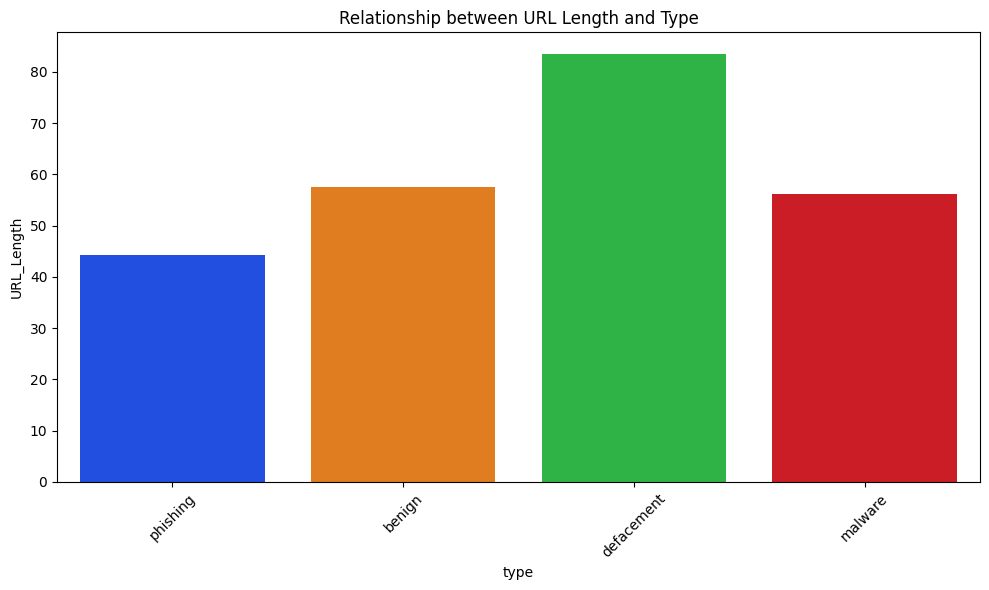

In [18]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='type', y='URL_Length',palette="bright", ci=None)
plt.title("Relationship between URL Length and Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_16736\1237545503.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='type', y='type_ratio', ci=None, palette='bright')
C:\Users\Dell\AppData\Local\Temp\ipykernel_16736\1237545503.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='type', y='type_ratio', ci=None, palette='bright')


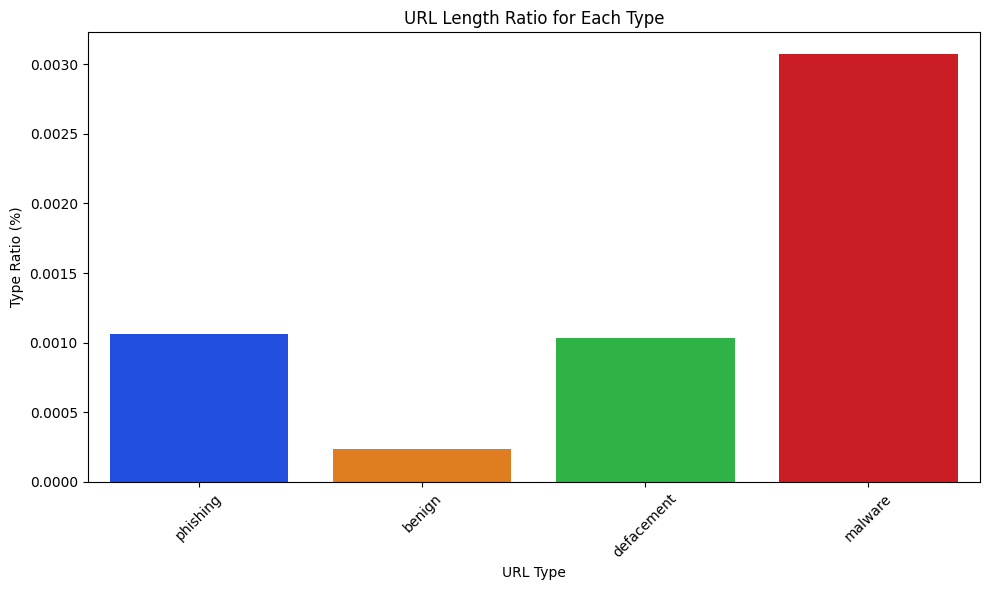

In [19]:
# Calculate the ratios for each URL type within the same type
data['type_ratio'] = data.groupby('type')['URL_Length'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='type', y='type_ratio', ci=None, palette='bright')
plt.title("URL Length Ratio for Each Type")
plt.ylabel("Type Ratio (%)")
plt.xlabel("URL Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
data.head()

,url,type,Category,URL_Length,type_ratio
0,br-icloud.com.br,phishing,2,16,0.000384
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916


In [21]:
# Function to extract domain from URL using tldextract
def extract_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"

# Add a new 'domain' column with the extracted domain from each URL
data['domain'] = data['url'].apply(extract_domain)

In [22]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net


In [23]:
# List of characters to count
characters_to_count = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

# Function to count occurrences of a character in a URL
def count_character_occurrences(url, character):
    return url.count(character)

# Add new columns for each character and count occurrences
for character in characters_to_count:
    data[f'{character}'] = data['url'].apply(lambda url: count_character_occurrences(url, character))


In [24]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [25]:
# Function to detect if there's a match between URL and host
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

# Add a new 'Abnormal_URL' column with 1 if there's a match, 0 otherwise
data['Abnormal_URL'] = data['url'].apply(abnormal_url)

In [26]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,Abnormal_URL
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


C:\Users\Dell\AppData\Local\Temp\ipykernel_16736\3914655358.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Abnormal_URL', data=data, palette="bright")


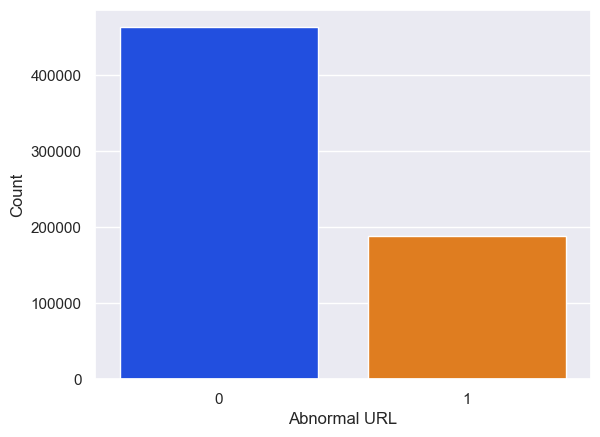

In [27]:
sns.set_theme(style="darkgrid")
sns.countplot(x='Abnormal_URL', data=data, palette="bright")
plt.xlabel('Abnormal URL')
plt.ylabel('Count')
plt.show()

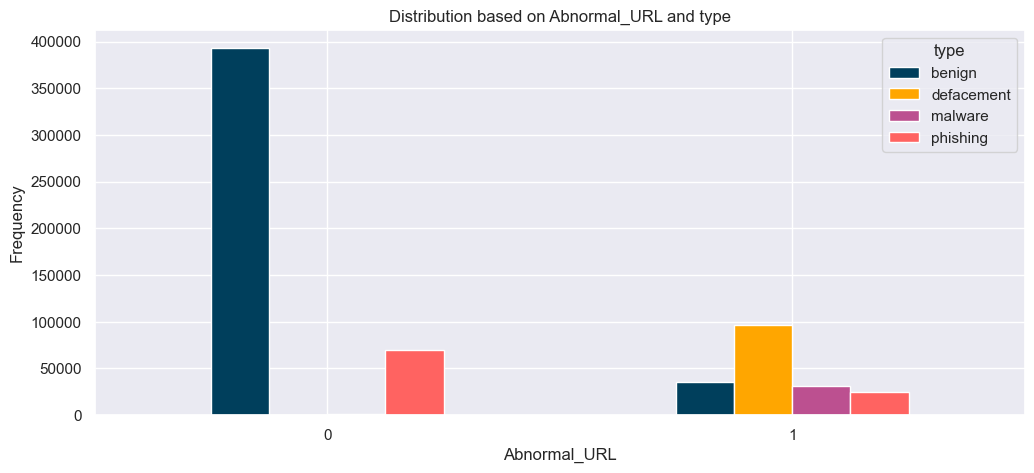

In [28]:
# Create a crosstab and plot the bar chart
pd.crosstab(data["Abnormal_URL"], data["type"]).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#bc5090','#ff6361'])
plt.title('Distribution based on Abnormal_URL and type')
plt.xlabel('Abnormal_URL')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="type")
plt.show()

In [29]:
# Function to detect if the URL has "https"
def has_https(url):
    return int("https" in url)

# Add a new 'Has_HTTPS' column with 1 if there's "https", 0 otherwise
data['Has_HTTPS'] = data['url'].apply(has_https)

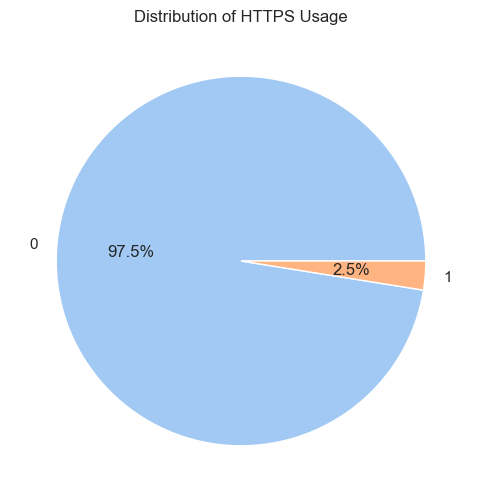

In [30]:
# Count the occurrences of each value in the "Has_HTTPS" column
https_counts = data['Has_HTTPS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(https_counts, labels=https_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of HTTPS Usage')
plt.show()

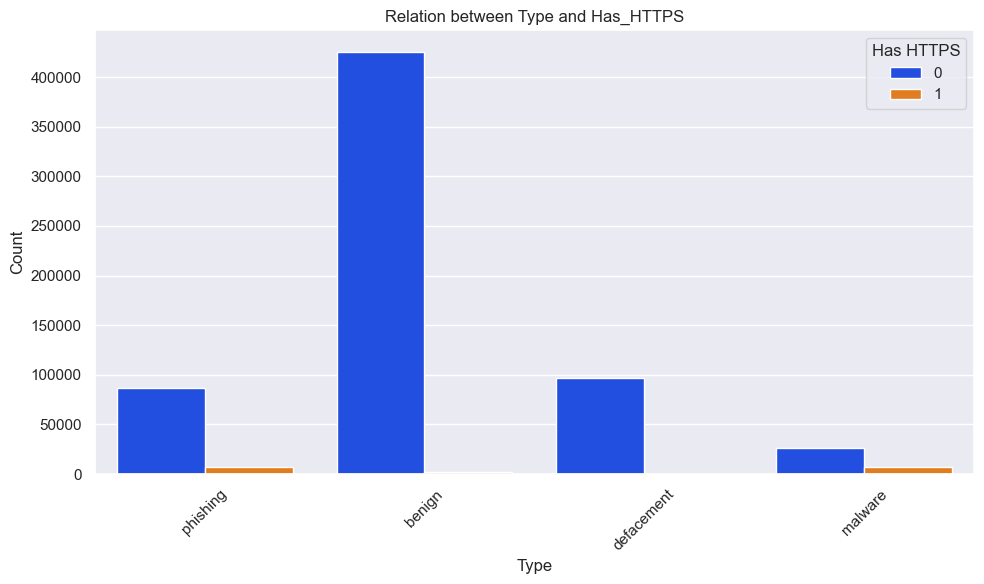

In [31]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_HTTPS',palette="bright")
plt.title("Relation between Type and Has_HTTPS")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has HTTPS")
plt.tight_layout()
plt.show()

In [32]:
# Function to count the number of digits in a string
def count_digits(string):
    return sum(1 for char in string if char.isdigit())

# Function to count the number of letters in a string
def count_letters(string):
    return sum(1 for char in string if char.isalpha())

# Add new columns for digit and letter counts
data['Digit_Count'] = data['url'].apply(count_digits)
data['Letter_Count'] = data['url'].apply(count_letters)

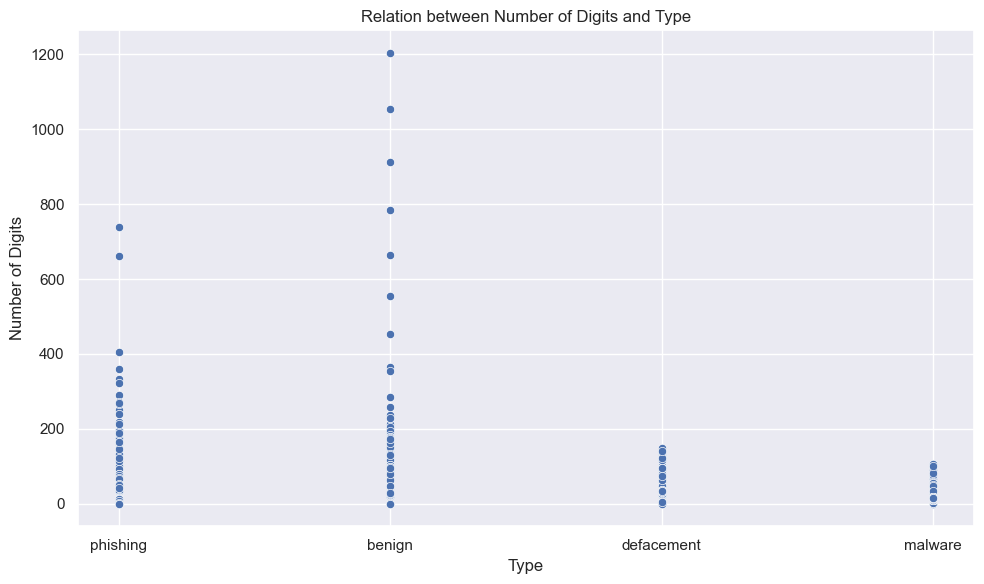

In [33]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='Digit_Count')
plt.title("Relation between Number of Digits and Type")
plt.xlabel("Type")
plt.ylabel("Number of Digits")
plt.tight_layout()
plt.show()

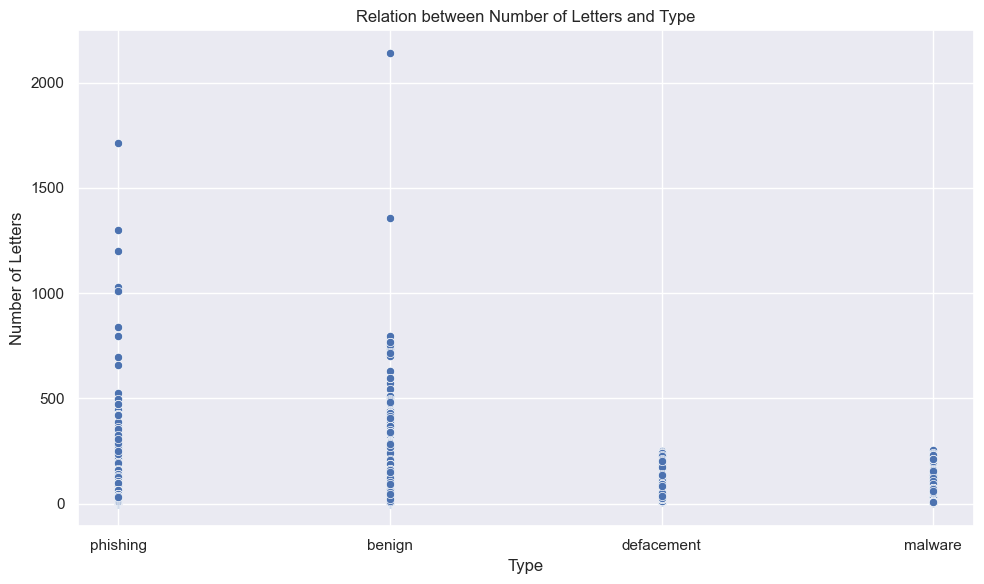

In [34]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='type', y='Letter_Count')
plt.title("Relation between Number of Letters and Type")
plt.xlabel("Type")
plt.ylabel("Number of Letters")
plt.tight_layout()
plt.show()

In [35]:
# Define the regular expression pattern for shortening services
shortening_pattern = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                     r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                     r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                     r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                     r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                     r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                     r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                     r'tr\.im|link\.zip\.net'

# Function to detect if the URL uses a shortening service
def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

# Add a new 'Has_Shortening_Service' column with 1 if it has a shortening service, 0 otherwise
data['Has_Shortening_Service'] = data['url'].apply(has_shortening_service)


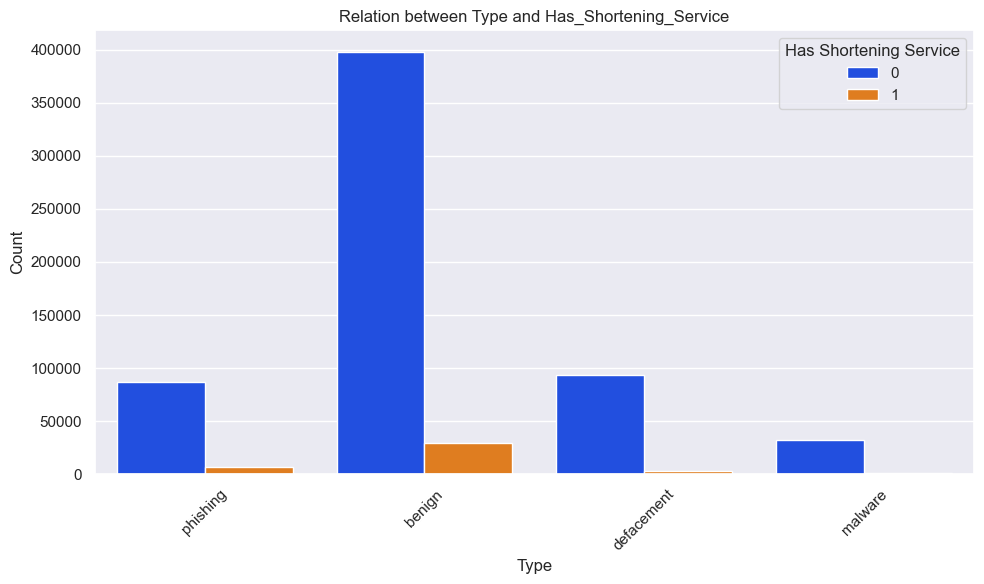

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_Shortening_Service',palette='bright')
plt.title("Relation between Type and Has_Shortening_Service")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()

In [37]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,$,!,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,0,1,1,0,22,199,0


In [38]:
# Define the regular expression pattern to match various IP address formats
ip_pattern = (
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'
    r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
    r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
    r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
)

# Function to detect if the URL has an IP address
def has_ip_address(url):
    return int(re.search(ip_pattern, url, flags=re.I) is not None)

# Add a new 'Has_IP_Address' column with 1 if it has an IP address, 0 otherwise
data['Has_IP_Address'] = data['url'].apply(has_ip_address)

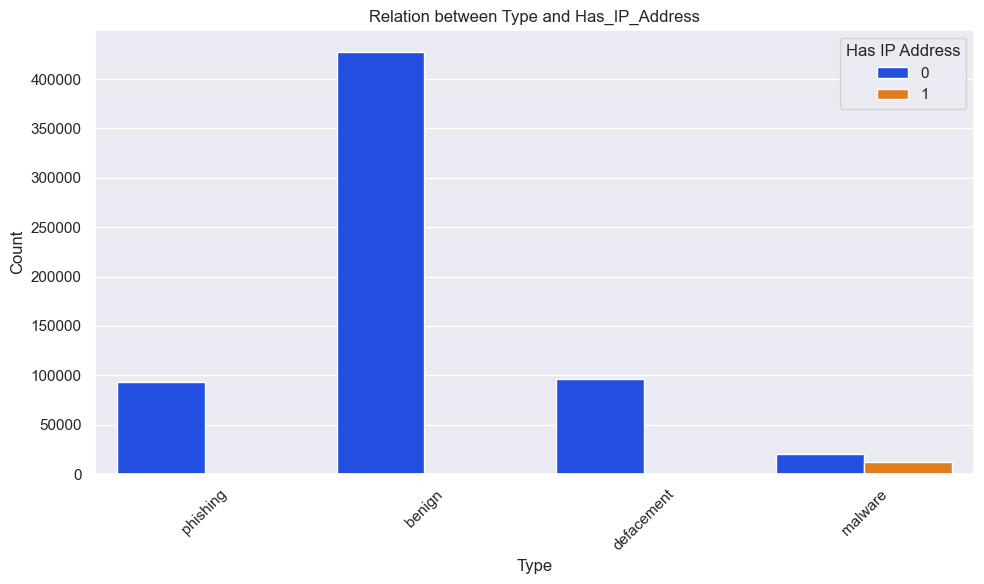

In [39]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_IP_Address',palette='bright')
plt.title("Relation between Type and Has_IP_Address")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()

In [40]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,!,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,1,1,0,22,199,0,0


In [41]:
# Function to check for malicious code in a URL
def check_for_malicious_code(url):
    # Check for 'javascript:' in the URL
    if re.search(r'javascript:', url):
        return 1
    
    # Check for attempts to inject script or use 'on' attributes
    if re.search(r'<\s*script', url, re.IGNORECASE) or re.search(r'on\w*=', url, re.IGNORECASE):
        return 1
    
    return 0

# Add a new 'Has_Malicious_Code' column with 1 if it has malicious code, 0 otherwise
data['Has_javascript_Code'] = data['url'].apply(check_for_malicious_code)


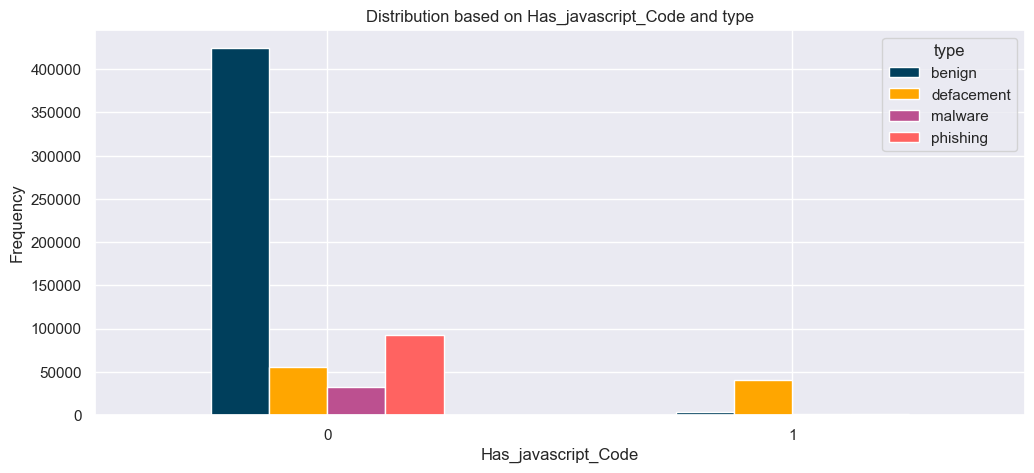

In [42]:
# Create a crosstab and plot the bar chart
pd.crosstab(data["Has_javascript_Code"], data["type"]).plot(kind="bar", figsize=(12, 5),
                                                           color=['#003f5c', '#ffa600', '#bc5090', '#ff6361'])
plt.title('Distribution based on Has_javascript_Code and type')
plt.xlabel('Has_javascript_Code')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="type")
plt.show()

In [43]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,*,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,1,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,1,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,1,1,0,7,60,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,1,1,0,22,199,0,0,1


In [44]:
# Define the function to check text encoding
def check_text_encoding(url):
    # Parse the URL
    parsed_url = urlparse(url)

    # Extract the text part
    text_part = parsed_url.path

    # Check for encoding
    decoded_text = unquote(text_part)
    
    # Check if the decoded text matches the original text
    if decoded_text == text_part:
        return 0  # No encoding found
    else:
        return 1  # Encoding found

# Apply the function to the 'url' column and create a new column 'Has_Text_Encoding'
data['Has_Text_Encoding'] = data['url'].apply(check_text_encoding)



In [45]:
data.head()

,url,type,Category,URL_Length,type_ratio,domain,@,?,-,=,...,",",//,Abnormal_URL,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code,Has_Text_Encoding
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,1,29,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,1,25,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,1,1,0,7,60,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,1,1,0,22,199,0,0,1,0


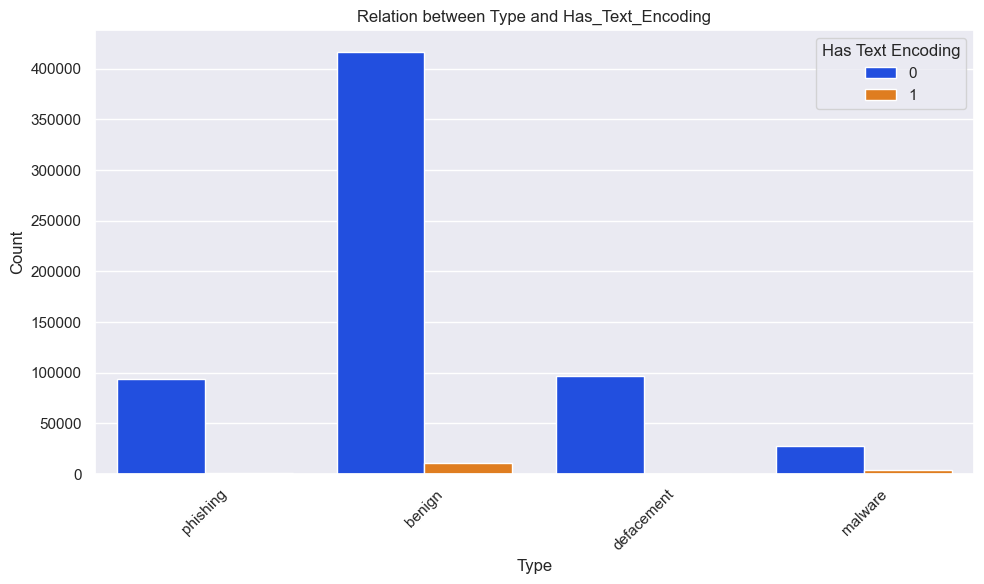

In [46]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='type', hue='Has_Text_Encoding',palette='bright')
plt.title("Relation between Type and Has_Text_Encoding")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Text Encoding")
plt.tight_layout()
plt.show()

In [47]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

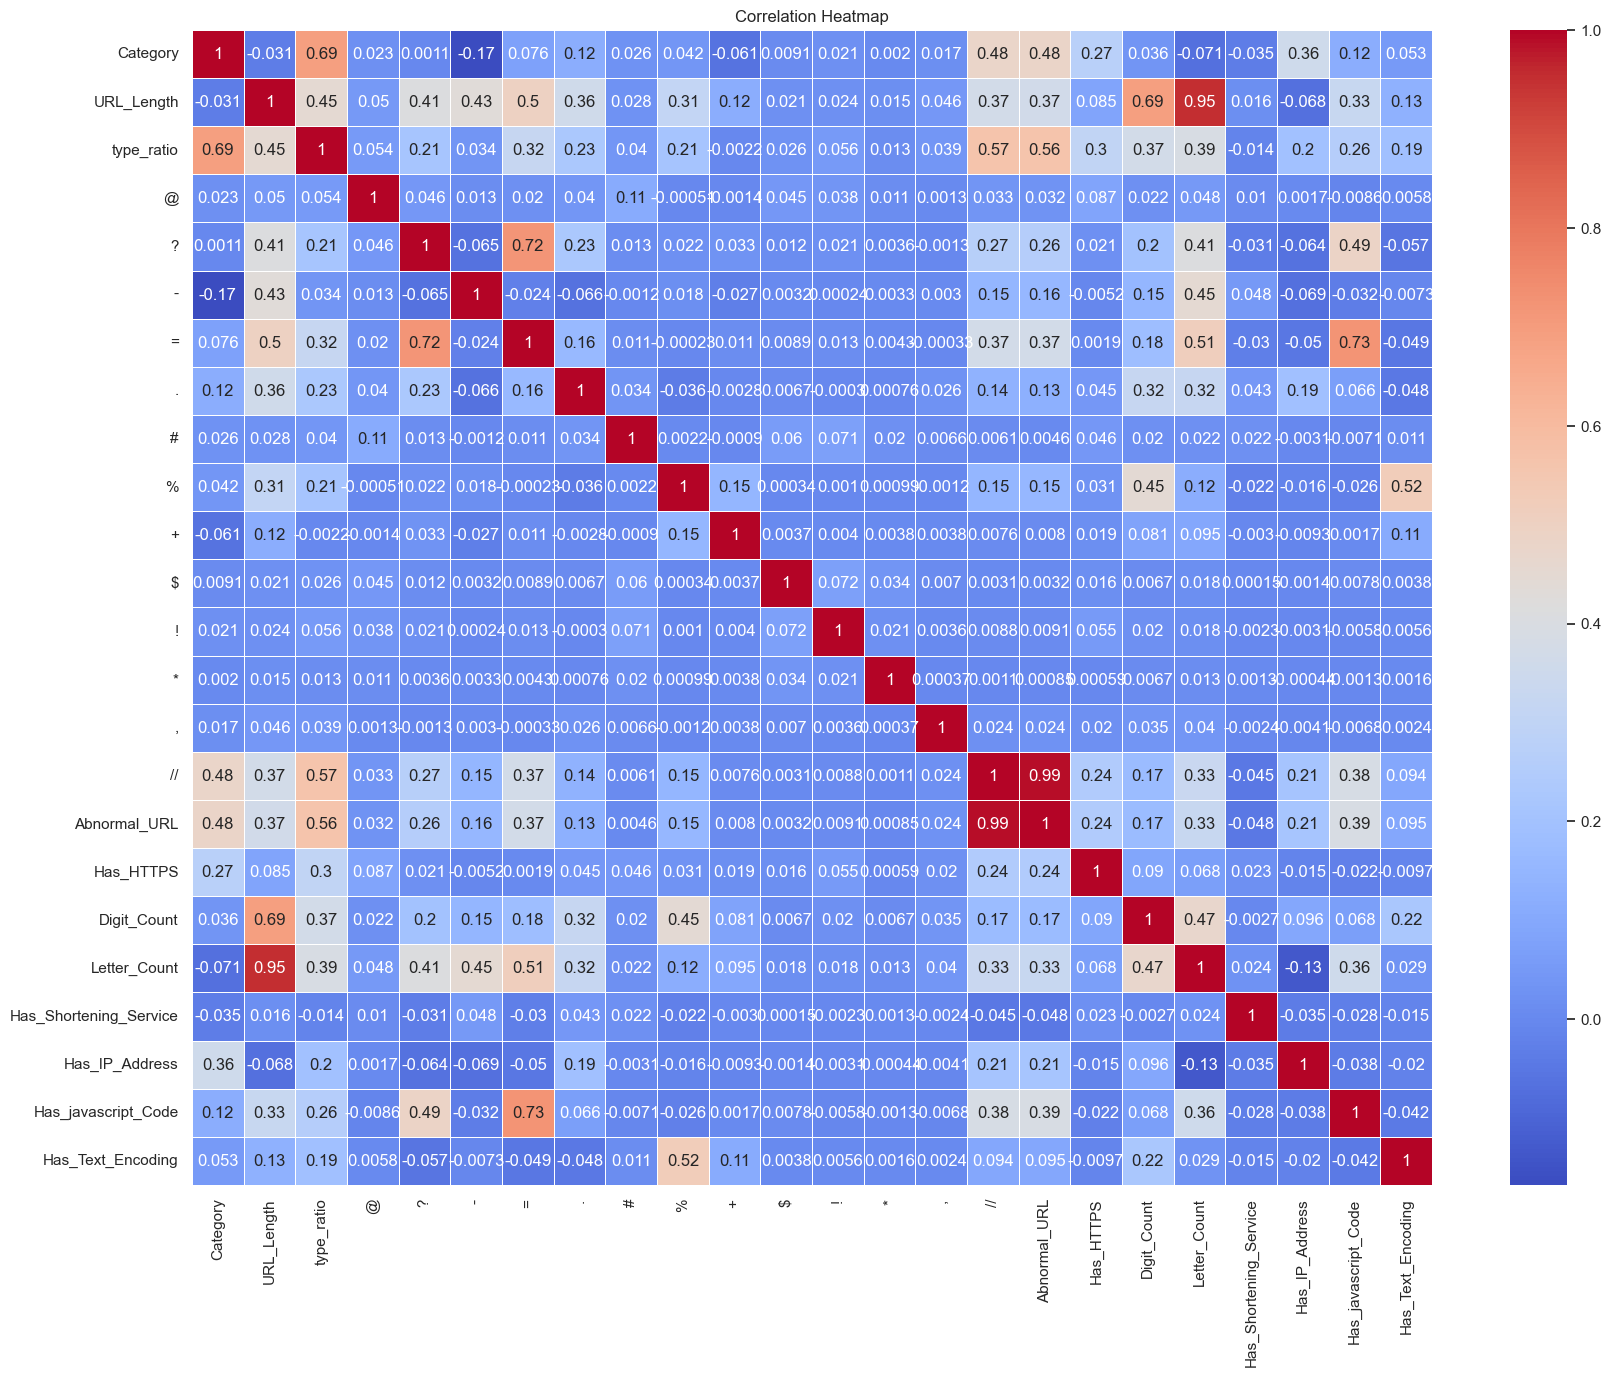

In [48]:
# Calculate correlations between columns
correlation_matrix = numerical_data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

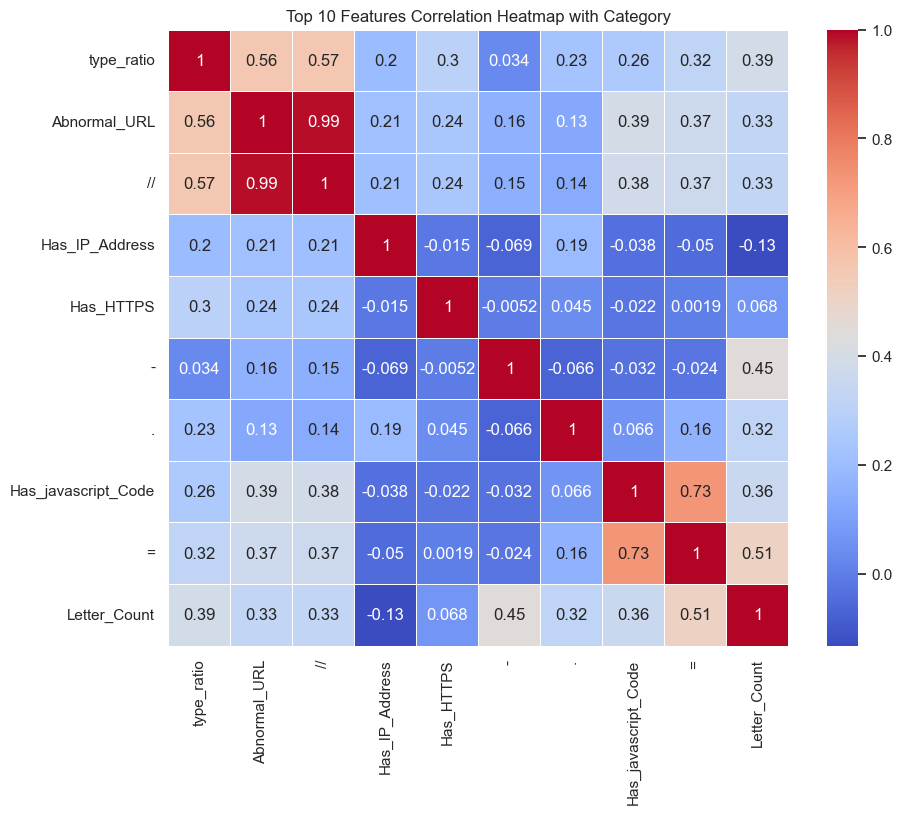

In [49]:
# Select the top 10 features related to the "Category" column
top_features = numerical_data.corr().abs()['Category'].sort_values(ascending=False)[1:11].index

# Calculate correlations for the selected features
correlation_matrix = numerical_data[top_features].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Top 10 Features Correlation Heatmap with Category")
plt.show()

In [50]:
data.isnull().sum()

url                       0
type                      0
Category                  0
URL_Length                0
type_ratio                0
domain                    0
@                         0
?                         0
-                         0
=                         0
.                         0
#                         0
%                         0
+                         0
$                         0
!                         0
*                         0
,                         0
//                        0
Abnormal_URL              0
Has_HTTPS                 0
Digit_Count               0
Letter_Count              0
Has_Shortening_Service    0
Has_IP_Address            0
Has_javascript_Code       0
Has_Text_Encoding         0
dtype: int64

In [51]:
X = data.drop(['url','type','Category','domain','type_ratio','*'],axis=1)#,'type_code'
y = data['Category']

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (520952, 21)
X_test shape: (130239, 21)
y_train shape: (520952,)
y_test shape: (130239,)


JUST TO TAKE SOME RANDOM SAMPLES TO TEST IN THE predict.py

In [1]:
import random
import math

# Function to randomly select a specified number of instances for testing
def random_sample(data, test_size):
    # Ensure test_size is not larger than the DataFrame
    if isinstance(test_size, float):
        if 0 < test_size < 1:
            test_size = math.ceil(test_size * len(data))
        else:
            raise ValueError("test_size should be a float between 0 and 1, or an integer.")
    elif isinstance(test_size, int):
        if test_size > len(data):
            raise ValueError("test_size is larger than the number of rows in the DataFrame.")
    else:
        raise TypeError("test_size should be a float or an integer.")
    
    # Randomly select indices for the testing sample
    test_indices = random.sample(range(len(data)), test_size)
    
    # Create the testing DataFrame
    test_df = data.iloc[test_indices]
    return test_df

In [ ]:
test_df=random_sample(data,0.2)
test_df


In [55]:
X_test.columns


Index(['URL_Length', '@', '?', '-', '=', '.', '#', '%', '+', '$', '!', ',',
       '//', 'Abnormal_URL', 'Has_HTTPS', 'Digit_Count', 'Letter_Count',
       'Has_Shortening_Service', 'Has_IP_Address', 'Has_javascript_Code',
       'Has_Text_Encoding'],
      dtype='object')

In [56]:
data.columns

Index(['url', 'type', 'Category', 'URL_Length', 'type_ratio', 'domain', '@',
       '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//',
       'Abnormal_URL', 'Has_HTTPS', 'Digit_Count', 'Letter_Count',
       'Has_Shortening_Service', 'Has_IP_Address', 'Has_javascript_Code',
       'Has_Text_Encoding'],
      dtype='object')

In [57]:
# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (520952, 21)
X_test shape: (130239, 21)
y_train shape: (520952,)
y_test shape: (130239,)


Accuracy: 0.9144035196830442
Precision: 0.9103278356774589
Recall: 0.9144035196830442
F1 Score: 0.9083685245889845


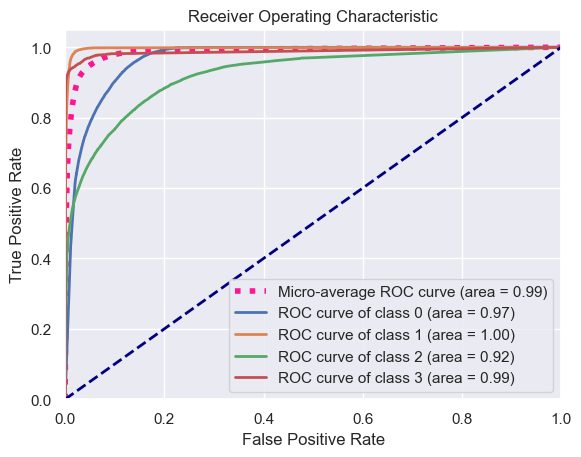

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Initialize and train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=clf.classes_)

# Calculate ROC AUC for each class
roc_auc = {}
fpr = {}
tpr = {}

for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(clf.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [67]:

# Save the trained model using joblib
joblib.dump(clf, 'trained_models\malicious_url_model_rfclf.joblib')

['trained_models\\malicious_url_model_rfclf.joblib']

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.815255031135067
AdaBoost Precision: 0.7723690920751383
AdaBoost Recall: 0.815255031135067
AdaBoost F1 Score: 0.7803538333980232


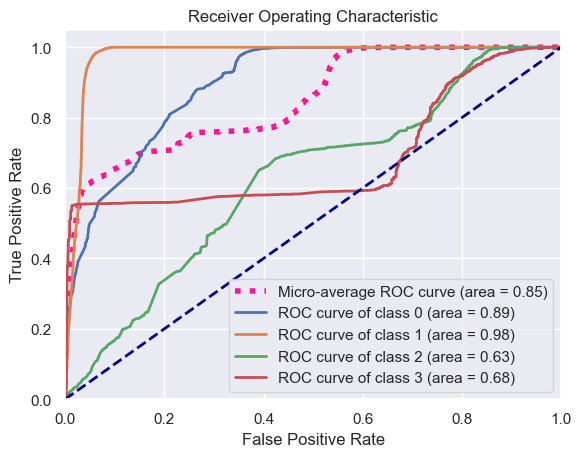

In [72]:
# Initialize and train the AdaBoostClassifier
ada_classifier = AdaBoostClassifier(random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0],      # Contribution of each weak learner
    'algorithm': ['SAMME', 'SAMME.R'],      # Algorithm for boosting
}

# Perform grid search
grid_search = GridSearchCV(estimator=ada_classifier, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_ada_classifier = AdaBoostClassifier(**best_params, random_state=42)
best_ada_classifier.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_ada = best_ada_classifier.predict(X_test)
y_pred_proba_ada = best_ada_classifier.predict_proba(X_test)

# Calculate evaluation metrics: accuracy, precision, recall, F1-score
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')

print("AdaBoost Accuracy:", accuracy_ada)
print("AdaBoost Precision:", precision_ada)
print("AdaBoost Recall:", recall_ada)
print("AdaBoost F1 Score:", f1_ada)

# Binarize the output for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=best_ada_classifier.classes_)

# Calculate ROC AUC for each class
roc_auc_ada = {}
fpr_ada = {}
tpr_ada = {}

for i in range(len(best_ada_classifier.classes_)):
    fpr_ada[i], tpr_ada[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_ada[:, i])
    roc_auc_ada[i] = auc(fpr_ada[i], tpr_ada[i])

# Compute micro-average ROC curve and ROC area
fpr_ada["micro"], tpr_ada["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_ada.ravel())
roc_auc_ada["micro"] = auc(fpr_ada["micro"], tpr_ada["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr_ada["micro"], tpr_ada["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_ada["micro"]))

for i in range(len(best_ada_classifier.classes_)):
    plt.plot(fpr_ada[i], tpr_ada[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(best_ada_classifier.classes_[i], roc_auc_ada[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [74]:
joblib.dump(best_ada_classifier, 'trained_models\malicious_url_model_adaclf.joblib')

['trained_models\\malicious_url_model_adaclf.joblib']

SGD Classifier Accuracy: 0.8203533503789188
SGD Classifier Precision: 0.8231202374778646
SGD Classifier Recall: 0.8203533503789188
SGD Classifier F1 Score: 0.7638821196489104


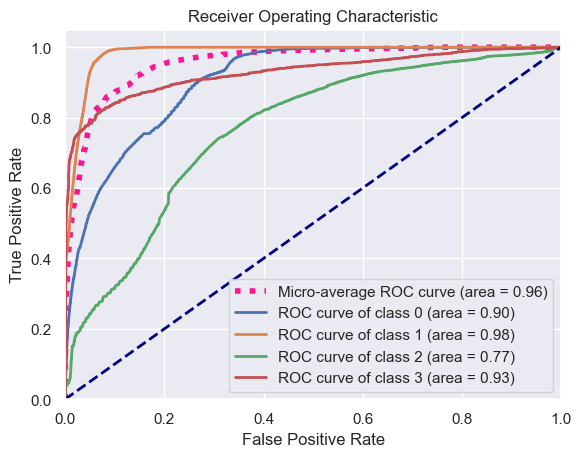

In [75]:
# Initialize SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)

# Fit the classifier directly without grid search
sgd_classifier.fit(X_train, y_train)

# Calibrate the model
calibrated_clf = CalibratedClassifierCV(sgd_classifier, cv="prefit")
calibrated_clf.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_sgd = calibrated_clf.predict(X_test)
y_pred_proba_sgd = calibrated_clf.predict_proba(X_test)

# Calculate the accuracy of the SGD model
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("SGD Classifier Accuracy:", accuracy_sgd)

# Calculate precision, recall, and F1-score
precision_sgd = precision_score(y_test, y_pred_sgd, average='weighted')
recall_sgd = recall_score(y_test, y_pred_sgd, average='weighted')
f1_sgd = f1_score(y_test, y_pred_sgd, average='weighted')

print("SGD Classifier Precision:", precision_sgd)
print("SGD Classifier Recall:", recall_sgd)
print("SGD Classifier F1 Score:", f1_sgd)

# Binarize the output for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=calibrated_clf.classes_)

# Calculate ROC AUC for each class
roc_auc_sgd = {}
fpr_sgd = {}
tpr_sgd = {}

for i in range(len(calibrated_clf.classes_)):
    fpr_sgd[i], tpr_sgd[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_sgd[:, i])
    roc_auc_sgd[i] = auc(fpr_sgd[i], tpr_sgd[i])

# Compute micro-average ROC curve and ROC area
fpr_sgd["micro"], tpr_sgd["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_sgd.ravel())
roc_auc_sgd["micro"] = auc(fpr_sgd["micro"], tpr_sgd["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr_sgd["micro"], tpr_sgd["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_sgd["micro"]))

for i in range(len(calibrated_clf.classes_)):
    plt.plot(fpr_sgd[i], tpr_sgd[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(calibrated_clf.classes_[i], roc_auc_sgd[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [76]:
joblib.dump(calibrated_clf, 'trained_models\malicious_url_model_sgdclf.joblib')

['trained_models\\malicious_url_model_sgdclf.joblib']

ExtraTrees Classifier Accuracy: 0.914196208508972
ExtraTrees Classifier Precision: 0.9102077555743368
ExtraTrees Classifier Recall: 0.914196208508972
ExtraTrees Classifier F1 Score: 0.9080241520550361


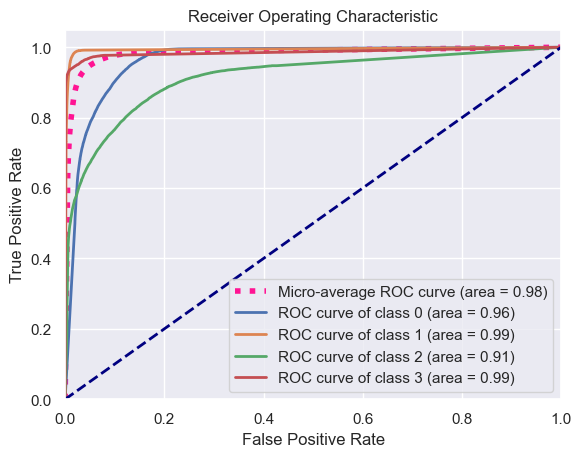

In [66]:
# Initialize and train the ExtraTreesClassifier
extra_trees_classifier = ExtraTreesClassifier(random_state=42)
extra_trees_classifier.fit(X_train, y_train)

# Predict the labels for the testing set
y_pred_extra_trees = extra_trees_classifier.predict(X_test)
y_pred_proba_extra_trees = extra_trees_classifier.predict_proba(X_test)

# Calculate the accuracy of the ExtraTrees model
accuracy_extra_trees = accuracy_score(y_test, y_pred_extra_trees)
print("ExtraTrees Classifier Accuracy:", accuracy_extra_trees)

# Calculate precision, recall, and F1-score
precision_extra_trees = precision_score(y_test, y_pred_extra_trees, average='weighted')
recall_extra_trees = recall_score(y_test, y_pred_extra_trees, average='weighted')
f1_extra_trees = f1_score(y_test, y_pred_extra_trees, average='weighted')

print("ExtraTrees Classifier Precision:", precision_extra_trees)
print("ExtraTrees Classifier Recall:", recall_extra_trees)
print("ExtraTrees Classifier F1 Score:", f1_extra_trees)

# Binarize the output
y_test_bin = label_binarize(y_test, classes=extra_trees_classifier.classes_)

# Calculate ROC AUC for each class
roc_auc_extra_trees = {}
fpr_extra_trees = {}
tpr_extra_trees = {}

for i in range(len(extra_trees_classifier.classes_)):
    fpr_extra_trees[i], tpr_extra_trees[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_extra_trees[:, i])
    roc_auc_extra_trees[i] = auc(fpr_extra_trees[i], tpr_extra_trees[i])

# Compute micro-average ROC curve and ROC area
fpr_extra_trees["micro"], tpr_extra_trees["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba_extra_trees.ravel())
roc_auc_extra_trees["micro"] = auc(fpr_extra_trees["micro"], tpr_extra_trees["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr_extra_trees["micro"], tpr_extra_trees["micro"], color='deeppink', linestyle=':', linewidth=4, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_extra_trees["micro"]))

for i in range(len(extra_trees_classifier.classes_)):
    plt.plot(fpr_extra_trees[i], tpr_extra_trees[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(extra_trees_classifier.classes_[i], roc_auc_extra_trees[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [68]:
joblib.dump(extra_trees_classifier, 'trained_models\malicious_url_model_extratreeclf.joblib')

['trained_models\\malicious_url_model_extratreeclf.joblib']

In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense

In [ ]:
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=10, batch_size=2)  # You can adjust the number of epochs and batch size

Epoch 1/10


260476/260476 [==============================] - 241s 921us/step - loss: -3786844.5000 - accuracy: 0.5482
Epoch 2/10
260476/260476 [==============================] - 253s 973us/step - loss: -58050316.0000 - accuracy: 0.5503
Epoch 3/10
260476/260476 [==============================] - 257s 987us/step - loss: -254335312.0000 - accuracy: 0.5499
Epoch 4/10
260476/260476 [==============================] - 228s 875us/step - loss: -686473472.0000 - accuracy: 0.5502
Epoch 5/10
260476/260476 [==============================] - 226s 868us/step - loss: -1447996800.0000 - accuracy: 0.5500
Epoch 6/10
260476/260476 [==============================] - 231s 887us/step - loss: -2628981760.0000 - accuracy: 0.5498
Epoch 7/10
260476/260476 [==============================] - 226s 867us/step - loss: -4331620352.0000 - accuracy: 0.5498
Epoch 8/10
260476/260476 [==============================] - 225s 866us/step - loss: -6638183936.0000 - accuracy: 0.5499
Epoch 9/10
260476/260476 [===================

In [ ]:
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test accuracy: {accuracy * 100:.2f}%')

4070/4070 [==============================] - 3s 798us/step - loss: -15638766592.0000 - accuracy: 0.5313
Test accuracy: 53.13%


RUN THIS AFTER TRAINING THE NEURAL NETWORK FOR MORE EPOCHS


In [ ]:
# joblib.dump(model, 'trained_models\malicious_url_model_neuralnetwork.joblib')

['trained_models\\malicious_url_model_neuralnetwork.joblib']